In [1]:
import logging
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import cv2
import tensorflow as tf
from pathlib import Path
from scipy.spatial import distance as mahal_distance

tf.keras.backend.clear_session()
from tensorflow.keras import layers
from tensorflow import keras
from tqdm import tqdm
import pickle
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd

import methods
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [2]:
encoder_net = keras.models.load_model('vae_encoder_net', compile=False)
decoder_net = keras.models.load_model('vae_decoder_net', compile=False)

In [3]:
inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers_loop = [testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC]
X_outliers_loop = [testImages_Artifact, testImages_Dirt, testImages_LD]

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [4]:
sample = encoder_net.predict(X_inliers[0].reshape(-1,32,32,1))

In [5]:
type(sample[0].reshape(256))

numpy.ndarray

In [6]:
decoded = decoder_net.predict(sample[2])

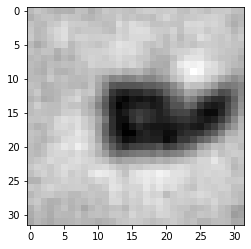

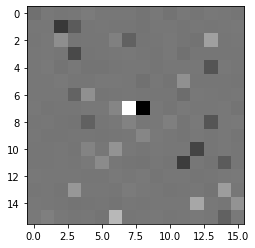

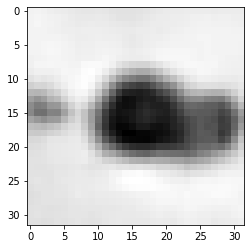

In [7]:
plt.imshow(X_inliers[0].reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(sample[0].reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(decoded.reshape(32, 32, 1), cmap="gray")
plt.show()

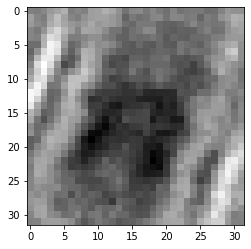

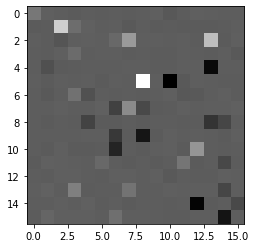

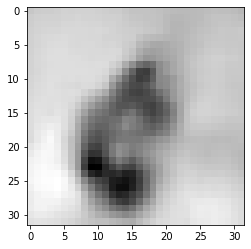

In [8]:
sample = encoder_net.predict(testImages_Dirt[0].reshape(-1,32,32,1))
decoded = decoder_net.predict(sample[2])
plt.imshow(testImages_Dirt[0].reshape(32, 32, 1), cmap="gray")
plt.show()
plt.imshow(sample[0].reshape(16, 16, 1), cmap="gray")
plt.show()
plt.imshow(decoded.reshape(32, 32, 1), cmap="gray")
plt.show()

In [9]:
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

In [18]:
# Mahalanobis
# get empirical class means and covariances
classes = np.array(['uCry', 'sCry', 'cCry', 'hCast', 'nhCast', 'sEC', 'nsEC', 'WBC', 'RBC'])
def get_mean_covariance(encoder):
    means= []
    observations = []
    for cl in classes:
        print("in class", cl)
        cl_path = "/home/thomas/tmp/patches_urine_32_scaled/"+cl+"/"
        counter = 0
        temp_array = None
        
        for img_path in Path(cl_path).glob("*.png"):
            counter += 1
            image = plt.imread(img_path)
            if counter == 1:
                temp_array = (encoder.predict(image.reshape(1, 32, 32, 1))).reshape(256)
                observations.append((encoder.predict(image.reshape(1, 32, 32, 1))).reshape(256))
            else:
                temp_array += (encoder.predict(image.reshape(1, 32, 32, 1))).reshape(256)
                observations.append((encoder.predict(image.reshape(1, 32, 32, 1))).reshape(256))
        means.append(temp_array/counter)
        
    V = np.cov(observations, rowvar=False)
    VM = np.matrix(V)
    
    return means, VM

# Returns the -mahal distance per class, max is better
def Mahal_distance(encoder, x, means, cov):
    np_output = (encoder.predict(x.reshape(1, 32, 32, 1))).reshape(256)
    
    mahal_distance_per_C = []
    for i in range(len(classes)):
        maha = mahal_distance.mahalanobis(np_output, means[i], cov)
        mahal_distance_per_C.append(maha)
        
    return mahal_distance_per_C

def test_mahala_final(encoder, means, covs, perturb, y_limit=None):
    covi = covs.I
    inlier_scores = []
    inlier_labels = []
    outlier_scores = []
    outlier_labels = []
    inlier_path = "/home/erdem/dataset/urine_test_32/inliers"
    outlier_path = "/home/erdem/dataset/urine_test_32/outliers"
    # Inliers
    for img_path in Path(inlier_path).glob("*.png"):
        inlier_labels.append(0)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        mahal_dist_per_c = Mahal_distance(encoder, image, means, covi)
        temp_score = np.amax(mahal_dist_per_c)
        inlier_scores.append(temp_score)
    
    # Outliers
    for img_path in Path(outlier_path).glob("*.png"):
        outlier_labels.append(1)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        mahal_dist_per_c = Mahal_distance(encoder, image, means, covi)
        temp_score = np.amax(mahal_dist_per_c)
        outlier_scores.append(temp_score)
    
    d_outliers = {"Mahalanobis Distance": outlier_scores, "outlier_labels": outlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    d_inliers = {"Mahalanobis Distance": inlier_scores, "inlier_labels": inlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    df1 = pd.DataFrame(data=d_inliers)
    df2 = pd.DataFrame(data=d_outliers)
    g = sns.scatterplot(data=df1, x="Index of Image Patches", y="Mahalanobis Distance")
    g = sns.scatterplot(data=df2, x="Index of Image Patches", y="Mahalanobis Distance")
    g.set(ylim=(0, y_limit))
    score_array = inlier_scores+outlier_scores
    label_array = inlier_labels+outlier_labels

    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
    plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)

In [23]:
means, COV= get_mean_covariance(encoder_net)

in class uCry
in class sCry
in class cCry
in class hCast
in class nhCast
in class sEC
in class nsEC
in class WBC
in class RBC


{'fpr_at_95_tpr': 0.9795597484276729, 'detection_error': 0.5, 'auroc': 0.4922570309718762, 'aupr_out': 0.5165444327078097, 'aupr_in': 0.47898510653847987}


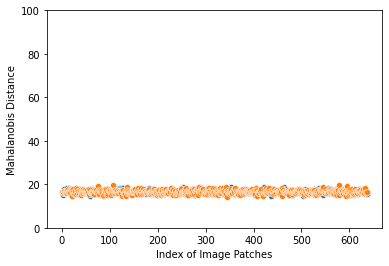

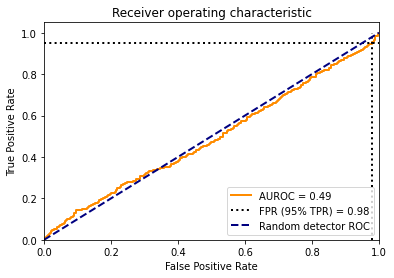

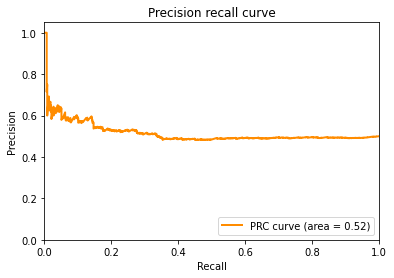

In [24]:
# cnn without the linear last layer
test_mahala_final(encoder_net, means, COV, perturb = None, y_limit = 100)

{'fpr_at_95_tpr': 0.6210691823899371, 'detection_error': 0.33490566037735847, 'auroc': 0.8531728373086507, 'aupr_out': 0.8752010834236622, 'aupr_in': 0.8214767201611772}


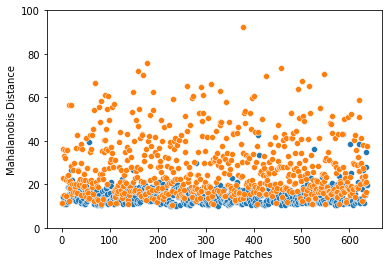

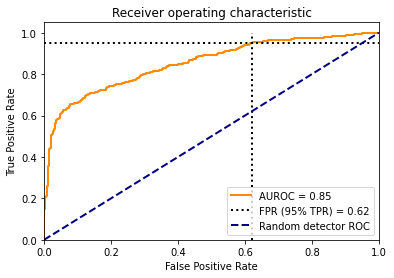

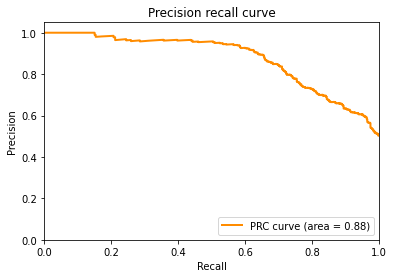

In [35]:
# cnn without the linear last layer
test_mahala_final(encoder_net, means, COV, perturb = None, y_limit = 100)

{'fpr_at_95_tpr': 0.7437106918238994, 'detection_error': 0.39544025157232704, 'auroc': 0.8813115580871009, 'aupr_out': 0.9039661214356567, 'aupr_in': 0.8302940927956703}


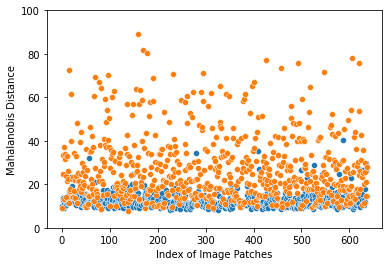

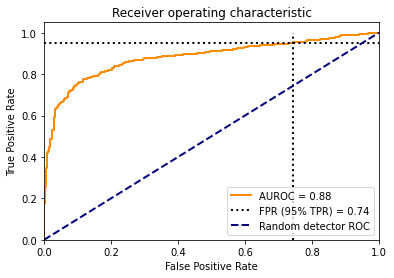

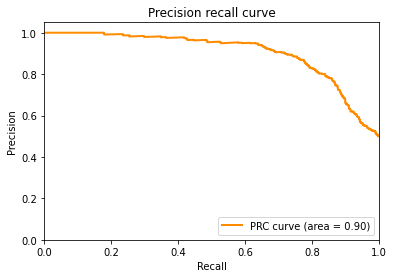

In [12]:
# cnn without the linear last layer
test_mahala_final(encoder_net, means, COV, perturb = None, y_limit = 100)

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

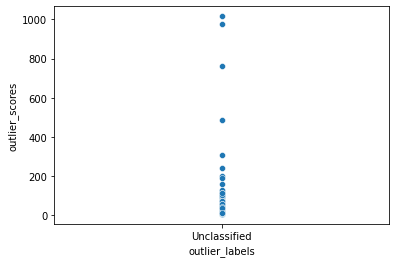

In [16]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
covi = COV.I
cl = "Unclassified"  
for img_path in Path(cl_path).glob("*.png"):
    outlier_path.append(img_path)
    outlier_labels.append(cl)
    image = plt.imread(img_path)
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
    mahal_dist_per_c = Mahal_distance(encoder_net, image, means, covi)
    temp_score = np.amax(mahal_dist_per_c)
    outlier_scores.append(temp_score)
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [17]:
sorted_unclassified = df3.sort_values(by=['outlier_scores'])

In [18]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))

In [21]:
means2, COV2= get_mean_covariance(encoder_net2)
# cnn without the linear last layer


in class uCry
in class sCry
in class cCry
in class hCast
in class nhCast
in class sEC
in class nsEC
in class WBC
in class RBC


{'fpr_at_95_tpr': 0.7358490566037735, 'detection_error': 0.3922955974842767, 'auroc': 0.8748862782326647, 'aupr_out': 0.8966703223994965, 'aupr_in': 0.8283229966779261}


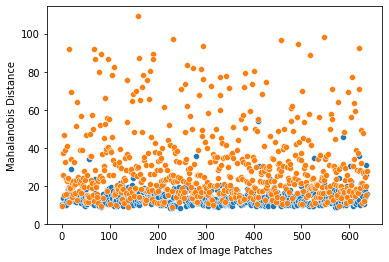

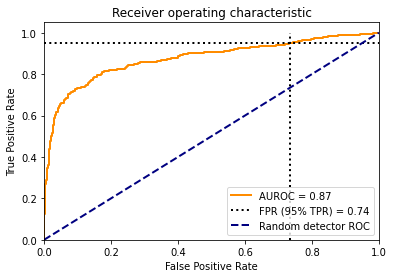

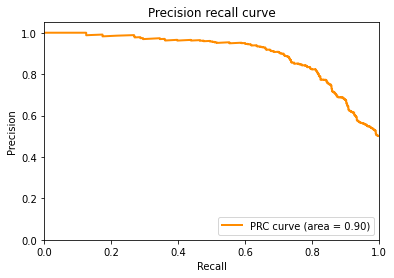

In [22]:
test_mahala_final(encoder_net2, means2, COV2, perturb = None)

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

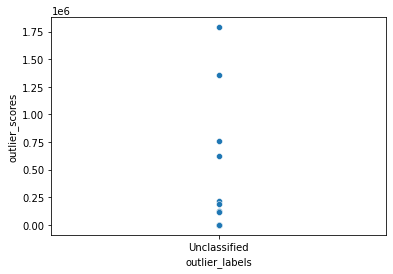

In [24]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
covi = COV2.I
cl = "Unclassified"  
for img_path in Path(cl_path).glob("*.png"):
    outlier_path.append(img_path)
    outlier_labels.append(cl)
    image = plt.imread(img_path)
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
    mahal_dist_per_c = Mahal_distance(encoder_net2, image, means2, covi)
    temp_score = np.amax(mahal_dist_per_c)
    outlier_scores.append(temp_score)
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [25]:
sorted_unclassified = df3.sort_values(by=['outlier_scores'])

In [26]:
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))

In [29]:
index = 0
# index: 717 and after is inlier
for a in sorted_unclassified['outlier_scores']:
    print(index, a)
    index += 1

0 52.66698666113644
1 53.107372001994065
2 53.33200152983145
3 53.38453247154915
4 53.579766755914406
5 53.639410279907345
6 53.661428285611855
7 53.89496530661629
8 53.8976446336155
9 53.92426711743867
10 54.01812544507931
11 54.035470528741044
12 54.03791476364166
13 54.05525324699496
14 54.06589102914704
15 54.06929591599398
16 54.08078549299699
17 54.099939098084654
18 54.10383445128292
19 54.11877664464086
20 54.12410690117134
21 54.131205756833936
22 54.15831978914079
23 54.1741792243035
24 54.21293075968691
25 54.22899663839957
26 54.23327918953569
27 54.25470063312342
28 54.26729990627163
29 54.267309534843946
30 54.27733443432729
31 54.310635050722176
32 54.3301597014108
33 54.330505918465654
34 54.3311768902484
35 54.33521401487924
36 54.34212714269254
37 54.34711074891208
38 54.35782408843903
39 54.38297247700437
40 54.39103529009837
41 54.39212755162302
42 54.39351321070729
43 54.40633671109741
44 54.409206937502205
45 54.43642802680311
46 54.447077926162784
47 54.473283980

1242 57.724796546357666
1243 57.727614688873764
1244 57.74014150982824
1245 57.74284000780305
1246 57.743102668802216
1247 57.744012303808944
1248 57.74524207042882
1249 57.74545293052576
1250 57.74624433719096
1251 57.74637856769162
1252 57.74822951506735
1253 57.75175900150744
1254 57.75300462107355
1255 57.75758321975344
1256 57.75970957466992
1257 57.7617657240036
1258 57.76190082529156
1259 57.76292381543897
1260 57.76353279163129
1261 57.76536762663499
1262 57.76719890607951
1263 57.76929121366107
1264 57.77042197513811
1265 57.77280017444508
1266 57.77394295413947
1267 57.77428111684918
1268 57.77916565354616
1269 57.7801141865805
1270 57.78245684374053
1271 57.788423471371594
1272 57.78909256587394
1273 57.79337714586933
1274 57.80233735600565
1275 57.80279922752396
1276 57.80342228230874
1277 57.809412858444006
1278 57.81272580374941
1279 57.81911218294399
1280 57.82080085965912
1281 57.82191316419557
1282 57.82303647197698
1283 57.82354770212529
1284 57.82472819016472
1285 57